In [1361]:
import pandas as pd
from tqdm import tqdm
import gensim
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# os.chdir(r"D://Proposal_Defense//Simulations")
# from Utils.Script_utils import get_data_splits, first_LSTM_training, get_data_splits_old_algo
from joblib import Parallel, delayed
import sys
from scipy.stats import norm

In [1362]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# # 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")
# tf.config.set_visible_devices([], 'GPU')

from tqdm.notebook import tqdm
tf.random.set_seed(seed_value)
import multiprocessing
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
# from keras import backend as K
# session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# K.set_session(sess)

No GPU found


In [1363]:
import matplotlib.pyplot as plt

import pickle

In [1364]:
model_cbow = gensim.models.word2vec.Word2Vec.load(r"..//Data_Generation//word2vec_sg")

In [1365]:
# data["high_level_substr"].value_counts()

In [1366]:
# data.head()

In [1367]:
reps = 50

In [1368]:
with open('..//Data_Generation//Data//train_valid_test_splits_50.pkl', 'rb') as f:
    catch = pickle.load(f)  

In [1369]:
with open('..//Data_Generation//LSTM_Heavy_Dropout//heavy_dropout_first_lstm.pkl', 'rb') as f:
    first_lstm = pickle.load(f)  

In [1370]:
with open('..//Data_Generation//Doc2Vec_ANN//doc2vec_ann.pkl', 'rb') as f:
    first_doc2vec_ann = pickle.load(f)  

    
# with open('..//Data_Generation//LSTM_Heavy_Dropout//Heavy_Data_train_logits.pkl', 'rb') as f:
#     catch_train_logits = (pickle.load(f))    

# with open('..//Data_Generation//LSTM_Heavy_Dropout//Heavy_Data_valid_logits.pkl', 'rb') as f:
#     catch_valid_logits = (pickle.load( f))      
    
# with open('..//Data_Generation//LSTM_Heavy_Dropout//Heavy_Data_test_logits.pkl', 'rb') as f:
#     catch_test_logits = (pickle.load( f))      
    

In [1371]:
def ann(hidden = 10): 
    input_layer = tf.keras.layers.Input(shape = (X_train_word2vec.shape[1]))
    hidden_layer = tf.keras.layers.Dense(hidden)
    hidden_output = hidden_layer(input_layer)
    pred_layer = tf.keras.layers.Dense(1)
    pred_output = pred_layer(hidden_output)
#     pred_output = tf.keras.layers.Activation("softmax")(pred_output)
    model = tf.keras.models.Model(input_layer, pred_output)
    return model

In [1372]:
h1, h2 = 16,16

In [1373]:
X_train_word2vec = first_lstm[0][3].numpy()

In [1374]:


ann_15 = ann(h1)


# In[35]:


# ann_15.summary()


# In[36]:



In [1375]:
ann_15.summary()

Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 25)]              0         
                                                                 
 dense_68 (Dense)            (None, 16)                416       
                                                                 
 dense_69 (Dense)            (None, 1)                 17        
                                                                 
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________


In [1376]:
X_train_word2vec = model_cbow.wv.vectors

In [1377]:
ann_20 = ann(h2)



# ann_20.summary()



In [1378]:
total_weights_1 = ann_15.count_params()

In [1379]:
total_weights_2 = ann_20.count_params()

In [1380]:
total_weights = total_weights_1 + total_weights_2 + 1 

In [1381]:
total_weights

1267

In [1382]:
## batch size
batch_size = 32

In [1383]:
# var_weights = 0.08
# var_targets = 0.08

In [1384]:
from scipy.stats import multivariate_normal as mvn

In [1385]:
from scipy.stats import invgamma, norm

In [1386]:
from tqdm.notebook import tqdm

In [1387]:
threshold = 5

In [1388]:
import random

In [1389]:
lr = 0.1

In [1390]:
import numpy as np

In [1391]:
weights_ann_1 = ann_15.get_weights()
weights_ann_2 = ann_20.get_weights()

In [1392]:
def get_targets_with_weights(batch_data, batch_data1, initial_ensembles, log_sigma_points_1): 

    n_hidden_1 = len(weights_ann_1[0].ravel())

    hidden_weights_1 = initial_ensembles[:,:n_hidden_1].reshape( size_ens, batch_data.shape[1], h1)

    
    hidden_output_1 = np.einsum('ij,kjl->kil', batch_data, hidden_weights_1)

    
    hidden_layer_bias_1 = initial_ensembles[:,n_hidden_1:(n_hidden_1 + h1)].reshape(size_ens, 1,  h1)



    hidden_output_1 = hidden_output_1 + hidden_layer_bias_1

    n_pred_weights_1 = len(weights_ann_1[2].ravel())

    output_weights_1 = initial_ensembles[:,(n_hidden_1 + h1):(n_hidden_1 + h1 + n_pred_weights_1) ].reshape(size_ens, h1, 1)

    output_1 = np.einsum('ijk,ikl->ijl', hidden_output_1, output_weights_1)


    output_layer_bias_1 = initial_ensembles[:,(n_hidden_1 + h1 + n_pred_weights_1):(n_hidden_1 + h1 + n_pred_weights_1 + 1)].reshape(size_ens, 1, 1)



    final_output_1 = output_1 + output_layer_bias_1

    n_hidden_2 = len(weights_ann_2[0].ravel())

    initial_ensembles_1 = initial_ensembles.copy()[:, total_weights_1:(total_weights_1+ total_weights_2)]

    hidden_weights_2 = initial_ensembles_1[:,:n_hidden_2].reshape(size_ens, batch_data1.shape[1], h2)



    hidden_output_2 = np.einsum('ij,kjl->kil', batch_data1, hidden_weights_2)

    hidden_layer_bias_2 = initial_ensembles[:,n_hidden_2:(n_hidden_2 + h2)].reshape(size_ens, 1,  h2)

    hidden_output_2 = hidden_output_2+ hidden_layer_bias_2

    n_pred_weights_2 = len(weights_ann_2[2].ravel())

    output_weights_2 = initial_ensembles_1[:,(n_hidden_2 + h2):(n_hidden_2 + h2 + n_pred_weights_2) ].reshape(size_ens, h2, 1)


    output_2 = np.einsum('ijk,ikl->ijl', hidden_output_2, output_weights_2)


    output_layer_bias_2 = initial_ensembles_1[:,(n_hidden_2 + h2 + n_pred_weights_2):(n_hidden_2 + h2 + n_pred_weights_2 + 1)].reshape(size_ens, 1, 1)


    final_output_2 = output_2 + output_layer_bias_2


    weights_1 = initial_ensembles[:, :total_weights_1]

    weights_2 = initial_ensembles[:, total_weights_1:(total_weights_1 + total_weights_2)]


    avg_weights = initial_ensembles[:, -1].reshape(-1,1)

    avg_weights_sig = expit(avg_weights)
    
    avg_weights_sig = avg_weights_sig.reshape(avg_weights_sig.shape[0], 1, avg_weights_sig.shape[1])
    
    complement_weights_sig = 1 - expit(avg_weights)
    
    complement_weights_sig = complement_weights_sig.reshape(complement_weights_sig.shape[0], 1, complement_weights_sig.shape[1])

    final_output_1 = final_output_1*complement_weights_sig
    
    final_output_2 = final_output_2*avg_weights_sig
    
    output_1_ravel = final_output_1.reshape(size_ens, final_output_1.shape[1]*final_output_1.shape[2])

    output_2_ravel = final_output_2.reshape(size_ens, final_output_2.shape[1]*final_output_2.shape[2])


    output_1_ravel = output_1_ravel

    output_2_ravel = output_2_ravel



    weights_1_add = np.zeros((size_ens, (total_weights_2 - total_weights_1)))



    weights_1 = np.hstack((weights_1, weights_1_add))
    


    stack_1 = np.hstack((output_1_ravel, weights_1, np.repeat(0, size_ens).reshape(-1,1), np.repeat(0, size_ens).reshape(-1,1)))



    
    stack_2 = np.hstack((output_2_ravel, weights_2, avg_weights, log_sigma_points_1))

    
    initial_aug_state = np.hstack((stack_1, stack_2)) 
    

    return initial_aug_state , output_1_ravel, output_2_ravel, log_sigma_points_1



In [1393]:
import time

In [1394]:
from scipy.stats import multivariate_normal as mvn

In [1453]:
var_weights =4
# var_weights_vec = 4
# var_targets = 0.04
# var_weights = 2

In [1396]:
from scipy.stats import multivariate_normal as mvn

In [1397]:
reduction = 4
# reduction = 10

In [1398]:
shape_needed = (total_weights + 2*batch_size*1 + 1 + (total_weights_2 - total_weights_1))//reduction

In [1399]:
size_ens = shape_needed

In [1400]:
size_ens = int(size_ens)

In [1401]:
size_ens

433

In [1402]:
# train_fudged_probs

In [1403]:
import matplotlib.pyplot as plt

In [1404]:
from scipy.special import expit

In [1405]:
# catch1[0][0]

In [1406]:
# catch_train_logits_second[0]

In [1407]:
from datetime import datetime

In [1408]:
def expit(x):
    """Compute softmax values for each sets of scores in x."""
#     e_x = np.exp(x - np.max(x))
    return 1 / (1 + np.exp(-x))

In [1409]:
from scipy.stats import gamma

In [1410]:
# second_lstm[0]

In [1411]:
# reduction = 8
# var_weights = 1

In [1412]:
# cur_idx = 16
# np.log(catch_test_probs[cur_idx]/(1-catch_test_probs[cur_idx]))

In [1413]:
# catch_preds_df

In [1414]:
# ids = [i for i in range(0, catch_test_probs[cur_idx].shape[0]) if catch_test_probs[cur_idx][i] < 0.5]
# ids_more = [i for i in range(0, catch_test_probs[cur_idx].shape[0]) if catch_test_probs[cur_idx][i] > 0.5]

In [1415]:
# ids_more

In [1416]:
import plotly.express as px

In [1417]:
import seaborn as sns

In [1418]:
use_cores = multiprocessing.cpu_count()-1

In [1419]:
use_cores = 15

In [1420]:
# threshold = 200
# cutoff_threshold = 70

In [1421]:
catch1 = first_lstm

In [1422]:
catch2 = first_doc2vec_ann

In [1423]:
from datetime import datetime

In [1424]:
#     idx = 0
#     X_train_logits_lstm = np.vstack((catch1[idx][0], catch1[idx][1]))
#     X_train_logits_doc2vec_ann = np.vstack((catch2[idx][0], catch2[idx][1]))
    
#     X_train_probs_lstm = expit(X_train_logits_lstm)
#     X_train_probs_doc2vec_ann = expit(X_train_logits_doc2vec_ann)

In [1425]:
# x = (X_train_probs_doc2vec_ann + X_train_probs_lstm)/2

In [1426]:
# X_train_logits_doc2vec_ann

In [1427]:
# X_train_logits_lstm

In [1428]:
# plt.scatter(X_train_logits_doc2vec_ann, X_train_logits_lstm)

In [1429]:
# np.log(x/(1-x))

In [1430]:
# X_train_probs_lstm

In [1431]:
# X_test_logits_lstm = catch1[idx][1]
# X_test_logits_doc2vec_ann = catch2[idx][1]

In [1432]:
# X_test_logits_lstm

In [1433]:
# X_test_logits_doc2vec_ann

In [1434]:
# X_test_logits_doc2vec_ann

In [1435]:
# X_test_logits_lstm

In [1459]:
def rep_one_real_world(idx, inflation_factor = 0.2, cutoff = 100): 
#     from scipy.special import expit
    patience_smaller = 0
# patience_bigger = 0

#     best_train_acc = 0
#     best_valid_acc = 1000

#     best_valid_mae = 10
    
    best_train_mae = 100
    
    X_train_logits_lstm = np.vstack((catch1[idx][0], catch1[idx][1]))
    X_train_logits_doc2vec_ann = np.vstack((catch2[idx][0], catch2[idx][1]))
    
    X_train_probs_lstm = expit(X_train_logits_lstm)
    X_train_probs_doc2vec_ann = expit(X_train_logits_doc2vec_ann)
    
    averaged_probs_lstm_doc2vec_ann_train = (X_train_probs_lstm + X_train_probs_doc2vec_ann)/2
    X_train_logits = np.log(averaged_probs_lstm_doc2vec_ann_train/(1-averaged_probs_lstm_doc2vec_ann_train))
    
    # X_train_logits = averaged_probs_lstm_doc2vec_ann_train
    
    
    X_test_logits_lstm = catch1[idx][2]
    X_test_logits_doc2vec_ann = catch2[idx][2]
    
    X_test_probs_lstm = expit(X_test_logits_lstm)
    X_test_probs_doc2vec_ann = expit(X_test_logits_doc2vec_ann)
    
    averaged_probs_lstm_doc2vec_ann_test = (X_test_probs_lstm + X_test_probs_doc2vec_ann)/2
    X_test_logits = np.log(averaged_probs_lstm_doc2vec_ann_test/(1-averaged_probs_lstm_doc2vec_ann_test))
    # X_test_logits = averaged_probs_lstm_doc2vec_ann_test
    
    ## create training batch chunks
    train_idx = list(range(0, X_train_logits.shape[0]))
    batch_chunks = [train_idx[i:i+batch_size] for i in range(0,len(train_idx),batch_size)]

    ## generate some augmented variable for iteration 0
    initial_aug_state_mean = np.repeat(0, total_weights)
    initial_aug_state_mean = initial_aug_state_mean.reshape(-1,1)

    initial_aug_state_cov = var_weights*np.identity((total_weights))
    initial_ensembles = mvn(initial_aug_state_mean.reshape(initial_aug_state_mean.shape[0],), initial_aug_state_cov).rvs(size = size_ens)

    
    log_sigma_points_1 = (np.log(gamma(100, scale = 1/100).rvs(size_ens))).reshape(size_ens, 1)
    

#     y_train = catch_train_labels_second[idx]

#     y_valid = catch_valid_labels_second[idx]

#     y_test = catch_test_labels_second[idx]
    
    
    train_lstm = catch1[idx][3].numpy()
    valid_lstm = catch1[idx][4].numpy()
    # valid_word2vec = catch[idx][7].iloc[catch_valid_idxes[idx],:].reset_index(drop = True)
    test_lstm = catch1[idx][5].numpy()
 

    train_doc2vec = []
    for seq in catch[idx][0]:
        seq_txt = seq[0]
        seq_split = seq_txt.split(" ")
        train_doc2vec.append(doc2vec_dbow.infer_vector(seq_split))
    train_doc2vec = np.array(train_doc2vec)
    
    valid_doc2vec = []
    for seq in catch[idx][1]:
        seq_txt = seq[0]
        seq_split = seq_txt.split(" ")
        valid_doc2vec.append(doc2vec_dbow.infer_vector(seq_split))
    valid_doc2vec = np.array(valid_doc2vec)
    
    test_doc2vec = []
    for seq in catch[idx][2]:
        seq_txt = seq[0]
        seq_split = seq_txt.split(" ")
        test_doc2vec.append(doc2vec_dbow.infer_vector(seq_split))
    test_doc2vec = np.array(test_doc2vec)    
    
    
    
    # train_valid_test_lstm = np.vstack((train_lstm, valid_lstm, test_lstm))
    # train_valid_test_doc2vec = np.vstack((train_doc2vec, valid_doc2vec, test_doc2vec))
    
    # train_valid_test_lstm = np.vstack((train_lstm, valid_lstm))
    # train_valid_test_doc2vec = np.vstack((train_doc2vec, valid_doc2vec))    
    
    train_valid_lstm = np.vstack((train_lstm, valid_lstm))
    train_valid_doc2vec = np.vstack((train_doc2vec, valid_doc2vec))    

    # best_width_train = 100
    
    # threshold_achieved = False
    # satisfactory = False
    # satisfactory_counter = 0
    
    
    best_coverage_train = 0
    
    start = datetime.now()
    
    for iter1 in range(0,500):

        for batch_idx in batch_chunks:

            batch_data = train_valid_lstm[batch_idx,:]
            batch_data1 = train_valid_doc2vec[batch_idx,:]
            # print(batch_data.shape)
            batch_targets = X_train_logits[batch_idx,:]
            # batch_targets = batch_targets.ravel().reshape(-1,1)

            column_mod_2_shape = total_weights_2 + batch_data.shape[0]*1 + 1 + 1
        
            H_t = np.hstack((np.identity(batch_targets.shape[0]), np.zeros((batch_targets.shape[0], column_mod_2_shape-batch_targets.shape[0]))))

            current_aug_state, column_mod_1, column_mod_2, log_sigma_points_1 = get_targets_with_weights(batch_data, batch_data1, initial_ensembles, log_sigma_points_1)
            
            var_targets_vec = np.log(1 + np.exp(log_sigma_points_1))
            
            var_targets_vec = var_targets_vec
            
            # current_aug_state_var = np.cov(current_aug_state.T) + inflation_factor*np.identity(current_aug_state.shape[1])
            
            current_aug_state_var = np.cov(current_aug_state.T) 
            
            G_t = np.array([1 , 1]).reshape(-1,1)
            
            scirpt_H_t = np.kron(G_t.T, H_t)
            
            temp1 = current_aug_state_var@scirpt_H_t.T
            
            temp2 = scirpt_H_t@current_aug_state_var@scirpt_H_t.T
        
            for ensemble_idx in range(0, current_aug_state.shape[0]):
                
                var_targets1 = var_targets_vec[ensemble_idx,:]
                
                R_t = var_targets1*np.identity(batch_targets.shape[0])
            
                measurement_error = mvn(np.repeat(0,batch_targets.shape[0]), var_targets1*np.identity(batch_targets.shape[0])).rvs(1).reshape(-1,1)
            
                target_current = batch_targets + measurement_error
                
                K_t = temp1@np.linalg.inv(temp2 + R_t)

                current_aug_state[ensemble_idx,:] = current_aug_state[ensemble_idx,:] +(K_t@(target_current -scirpt_H_t@current_aug_state[ensemble_idx,:].reshape(-1,1))).reshape(current_aug_state.shape[1],)
        

            weights_ann_1 = current_aug_state[:,batch_targets.shape[0]:(batch_targets.shape[0] + total_weights_1)]      

            weights_ann_2 = current_aug_state[:,-(total_weights_2+1):-2]    

            initial_ensembles = np.hstack((weights_ann_1, weights_ann_2, current_aug_state[:,-2].reshape(-1,1)))
            
            log_sigma_points_1 = current_aug_state[:,-1].reshape(-1,1)
               
            avg_betas = expit(current_aug_state[:,-2])
        
            complement = 1-avg_betas

            
            
            
            
            current_aug_state1, column_mod_11, column_mod_21, log_sigma_points_1 = get_targets_with_weights(train_valid_lstm, train_valid_doc2vec, initial_ensembles, log_sigma_points_1)
            
            initial_targets = column_mod_11 + column_mod_21
            
            
            initial_targets = initial_targets.reshape(size_ens, train_valid_lstm.shape[0],1)
            
            initial_targets_train = initial_targets
            
            
            
            
#             ind = (X_train_logits_true >= np.percentile(initial_targets_train, axis = 0, q = (2.5, 97.5))[0,:,:]) & (X_train_logits_true <= np.percentile(initial_targets_train, axis = 0, q = (2.5, 97.5))[1,:,:])
        
            initial_targets_softmax = expit(initial_targets)
        
            initial_softmax_train = initial_targets_softmax
            
            initial_targets_train_mean = initial_targets_softmax.mean(0)
            
            li = np.percentile(initial_targets_softmax, axis = 0, q = (2.5, 97.5))[0,:,:]
            
            ui = np.percentile(initial_targets_softmax, axis = 0, q = (2.5, 97.5))[1,:,:]
            
            width = ui - li
            
            avg_width_train = np.mean(width)
            
            # interim = np.vstack((catch_train_probs[idx] , catch_valid_probs[idx] ))
        
            interim = expit(X_train_logits)
            
            ind = (interim >= li) & (interim <= ui)
            
            coverage_train= np.mean(ind.ravel())  
            
            train_mae = np.mean(np.abs(interim.ravel() - initial_targets_train_mean.ravel()))
        
            current_aug_state1, column_mod_11, column_mod_21, log_sigma_points_1 = get_targets_with_weights(test_lstm, test_doc2vec, initial_ensembles, log_sigma_points_1)
            
            initial_targets = column_mod_11 + column_mod_21
            
            initial_targets = initial_targets.reshape(size_ens, test_lstm.shape[0],1)
            
            initial_targets_test = initial_targets
            
            initial_targets_softmax = expit(initial_targets)    
            
            initial_targets_test_mean = initial_targets_softmax.mean(0)
            
            li = np.percentile(initial_targets_softmax, axis = 0, q = (2.5, 97.5))[0,:,:]
            
            ui = np.percentile(initial_targets_softmax, axis = 0, q = (2.5, 97.5))[1,:,:]
            
            width = ui - li
            
            avg_width = np.mean(width)
            
            catch_test_probs = expit(X_test_logits)
            
            ind_test = (catch_test_probs >= li) & (catch_test_probs <= ui)
               

                        
            coverage_test = np.mean(ind_test.ravel())    

            # initial_targets_test_mean = initial_targets_train.mean(0)
    
            
            
            test_mae = np.mean(np.abs(catch_test_probs.ravel() - initial_targets_test_mean.ravel()))
       
        # print(avg_width_train, best_train_width, coverage_train)
        
#         print("epoch "+ str(iter1))
#         print("patience "+ str(patience_smaller))
#         print("train mae is " + str(train_mae))
#         print("test mae is " + str(test_mae))
        
#         print("train coverage is "+ str(coverage_train))
#         print("train width is " + str(avg_width_train))        
#         print("test coverage is "+ str(coverage_test))
#         print("test width is " + str(avg_width))
#         print("lstm weight is " + str(np.mean(complement)))
        # print("threshold " + str(threshold_achieved))
              
    
        if (train_mae < best_train_mae) & (coverage_train > 0.95): 
#             cur_best_train_width = avg_width_train
#             cur_best_test_width = avg_width

#             cur_best_train_coverage = coverage_train
#             cur_best_test_coverage = coverage_test 
#             cur_best_lstm_weight = np.mean(complement)
            best_train_mae = train_mae
            best_test_mae = test_mae
            exit_iter_no_thresh = iter1
            best_test_preds = initial_targets_softmax
            patience_smaller = 0
            best_train_coverage = coverage_train
            best_test_coverage = coverage_test
            best_train_width = avg_width_train
            best_test_width = avg_width
            best_lstm_weight = np.mean(complement)
            # satisfactory = True
            
        else:
            patience_smaller+=1
            
        if patience_smaller > threshold:
            
            break
            
        if (patience_smaller > cutoff_threshold) & (train_mae < 0.05):
            
            break
            
            
    print(best_test_mae,best_test_coverage, best_test_width, flush = True)
    end = datetime.now()
    total = (end-start)
    time_taken = total.seconds/60.0
    return best_train_mae, best_test_mae, best_train_coverage, best_train_width, best_test_coverage, best_test_width, best_lstm_weight,   exit_iter_no_thresh, time_taken, best_test_preds
        
    # print("something went awry", flush = True)

In [1449]:
threshold = 200

In [1450]:
cutoff_threshold = 100

In [1451]:
doc2vec_dbow = gensim.models.doc2vec.Doc2Vec.load(r"..//Data_Generation//doc2vec_dbow")

In [1460]:
# best_train_mae, best_test_mae, best_train_coverage, best_train_width, best_test_coverage, best_test_width, best_lstm_weight

In [1461]:
# best_train_mae, best_test_mae, best_train_coverage, best_train_width, best_test_coverage, best_test_width, best_lstm_weight,   exit_iter_no_thresh, time_taken, best_test_preds = rep_one_real_world(9)

In [1462]:
catch_coverages = Parallel(n_jobs=15, verbose = 10, backend = "loky")(delayed(rep_one_real_world)(i) for i in range(reps))

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.


0.0469637623492763 1.0 0.40611779076850196
0.05566972323993734 1.0 0.2579933173967607


[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:  2.8min


0.08275721576572895 0.75 0.22123190758135336
0.07216199112132657 0.875 0.21287567319524814
0.04645284109030069 0.75 0.13870060925179317
0.03949286061302664 1.0 0.21881669471283424
0.034035208204759075 0.75 0.17774426725605996
0.03783427671509329 0.75 0.09543257835705672
0.04981048583960177 1.0 0.1865815962656564
0.049046895310370625 0.875 0.1920441579849418
0.06904370304916424 0.625 0.18627472570434914


[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:  3.8min


0.045099354332145764 0.75 0.16591675636331904
0.04884021082506596 0.875 0.12871225446430312
0.05066661712957478 0.75 0.14001839383850898
0.054514405014963255 0.75 0.15789724288197104
0.06799567834687956 1.0 0.27348417519991786
0.04246543693973005 1.0 0.2653339535217207
0.12586109965002207 0.375 0.22548724205750253
0.06765128599265857 0.875 0.2045918093687097
0.09082688460438096 0.5 0.1615050942840903


[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:  6.2min


0.07228268835954457 0.75 0.17296877572328506
0.06318119071863307 1.0 0.19843515791152536
0.054180280387227976 0.875 0.1725760597068752
0.026658042436528157 1.0 0.22398104390063844
0.08341485791943254 0.875 0.2621089133023008
0.0746811811753576 0.75 0.262299539224374
0.06688482458438805 0.625 0.15777763031166123


[Parallel(n_jobs=15)]: Done  27 out of  50 | elapsed:  7.7min remaining:  6.6min


0.08459312785056053 0.75 0.2297244689011808
0.12106104510492177 0.5 0.27512219205261723
0.026639265985876296 1.0 0.15473988349588969
0.028974916710206834 1.0 0.23114716375182387
0.08269201626220998 1.0 0.33457341422772
0.04741354282643415 1.0 0.25655248742259495


[Parallel(n_jobs=15)]: Done  33 out of  50 | elapsed:  8.9min remaining:  4.6min


0.05355986134479879 0.875 0.15744942279432997
0.07808443985493885 0.875 0.19447303772528723
0.03886868322586177 0.875 0.17779643098701742
0.08090689102773728 0.75 0.1428106286719227
0.05362906357350361 0.5 0.09905340900325153
0.11189142123324233 0.375 0.13770393146491208


[Parallel(n_jobs=15)]: Done  39 out of  50 | elapsed:  9.6min remaining:  2.7min


0.1652019839936814 0.625 0.25347187586870346
0.07142684410402242 0.75 0.1910397406993625
0.08573368935092221 0.5 0.1856861970713256
0.09663920844068964 0.75 0.22958033185167448
0.09687205086367835 0.625 0.1409654505861625
0.08571397092771538 0.75 0.15878063951076093


[Parallel(n_jobs=15)]: Done  45 out of  50 | elapsed: 11.4min remaining:  1.3min


0.06431183621403927 0.875 0.20252073308506946
0.07459310375905832 0.75 0.19028772879804134
0.09069152956439372 0.375 0.1274674589124544
0.060334736954579526 0.875 0.14199529318064436
0.10333627933000097 0.5 0.2127116171099207


[Parallel(n_jobs=15)]: Done  50 out of  50 | elapsed: 12.3min finished


In [1463]:
# catch_coverages

In [1464]:
check = pd.DataFrame(catch_coverages).iloc[:,:-1]

In [1465]:
# check

In [1466]:
# check

In [1467]:
# check.columns = ["train_mae", "test_mae", "avg_ci_width_train", "avg_ci_width_test", "avg_lstm_weight", "exit_iter", "exit_status"]

In [1468]:
check

,0,1,2,3,4,5,6,7,8
0,0.054401,0.046964,1.000000,0.366999,1.000,0.406118,0.445517,20,2.550000
1,0.026512,0.069044,0.984848,0.179578,0.625,0.186275,0.516101,75,3.700000
2,0.023458,0.048840,0.954545,0.100808,0.875,0.128712,0.502170,81,3.816667
3,0.032143,0.034035,0.954545,0.159381,0.750,0.177744,0.499660,51,3.166667
4,0.047097,0.072162,0.954545,0.244029,0.875,0.212876,0.495755,38,2.950000
5,0.026522,0.049047,1.000000,0.190660,0.875,0.192044,0.513296,64,3.483333
6,0.021162,0.050667,0.954545,0.103306,0.750,0.140018,0.499452,95,4.066667
7,0.030675,0.054514,0.954545,0.153962,0.750,0.157897,0.498002,115,4.516667
8,0.037821,0.049810,0.954545,0.177708,1.000,0.186582,0.499614,61,3.383333
9,0.031986,0.082757,0.969697,0.178237,0.750,0.221232,0.480165,28,2.716667


In [1469]:
check.columns = ["train_mae", "test_mae", "train_coverage", "train_width", "test_coverage", "test_width", "lstm_weight" ,"exit_iter", "time_taken"]

In [1470]:
check.mean()

train_mae          0.033131
test_mae           0.068433
train_coverage     0.964242
train_width        0.171720
test_coverage      0.780000
test_width         0.197851
lstm_weight        0.500666
exit_iter         58.700000
time_taken         3.142000
dtype: float64

In [1471]:
check_mean = check.mean().reset_index()

In [1472]:
check_mean.to_csv("Real_World_mean_metrics_ANN_LSTM_EnKF_LSTM_Doc2Vec_" + "var_weights_" + str(var_weights) + "_num_ens_" + str(size_ens) +  ".csv", index = False)

In [1473]:
check.std()

train_mae          0.007929
test_mae           0.027485
train_coverage     0.014279
train_width        0.052945
test_coverage      0.184819
test_width         0.058177
lstm_weight        0.020779
exit_iter         34.132545
time_taken         0.703185
dtype: float64

In [1474]:
check_std = check.std().reset_index()

In [1475]:
check_std.to_csv("Real_World_std_dev_metrics_ANN_LSTM_EnKF_LSTM_Doc2Vec_" + "var_weights_" + str(var_weights) + "_num_ens_" + str(size_ens)+  ".csv", index = False)

In [1476]:
check.std()/reps

train_mae         0.000159
test_mae          0.000550
train_coverage    0.000286
train_width       0.001059
test_coverage     0.003696
test_width        0.001164
lstm_weight       0.000416
exit_iter         0.682651
time_taken        0.014064
dtype: float64

In [1477]:
# with open("Real_World_EnKF_LSTM_Doc2Vec_" + "var_weights_" + str(var_weights) + "_num_ens_" + str(size_ens) + ".pkl", 'rb') as f:
#     catch_coverages = pickle.load(f)  

In [1478]:
# catch_coverages[0][-1].mean(0)

In [1479]:
# expit(catch1[0][2])

In [1493]:
true_preds = []
enkf_preds = []
for i in range(0,reps):
    all_preds = catch_coverages[i][-1]
    all_preds = all_preds.mean(0)
    catch_test_probs = (expit(catch1[i][2]) + expit(catch2[i][2]))/2
    true_probs = catch_test_probs.ravel().tolist()
    true_preds.append(true_probs)
    enkf_preds.append(all_preds.ravel().tolist())
    # plt.scatter(true_probs, all_preds.ravel().tolist())
    # plt.show()

In [1494]:
true_preds = [inner for item in true_preds for inner in item]

In [1495]:
enkf_preds = [inner for item in enkf_preds for inner in item]

In [1483]:
# len(true_preds)

In [1496]:
np.mean(np.abs(np.array(true_preds)-np.array(enkf_preds)))

0.0684328492125053

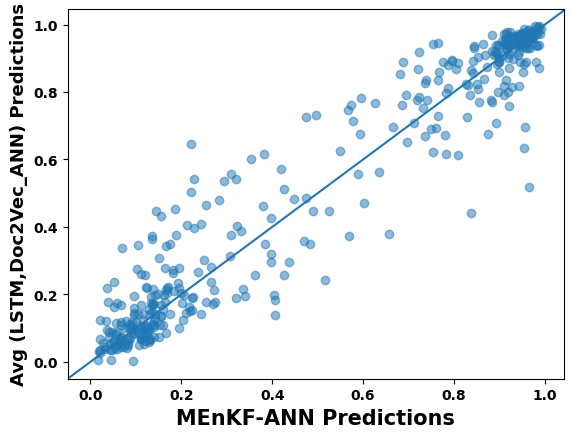

In [1497]:
plt.scatter(enkf_preds,true_preds, alpha=0.5)
plt.xlabel("MEnKF-ANN Predictions", fontsize = 15, fontweight = "bold")
plt.ylabel("Avg (LSTM,Doc2Vec_ANN) Predictions", fontsize = 13, fontweight = "bold")
plt.xticks(fontsize = 10, fontweight = "bold")
plt.yticks(fontsize = 10, fontweight = "bold")
plt.axline((0, 0), slope=1)
plt.show()

In [1486]:
with open("Real_World_ANN_LSTM_EnKF_LSTM_Doc2Vec_" + "var_weights_" + str(var_weights) + "_num_ens_" + str(size_ens) + ".pkl", 'wb') as f:
    first_lstm = pickle.dump(catch_coverages, f)  

In [1487]:
# check